In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split

fig_dpi = 200

%load_ext tensorboard

# Neural Network Training


## Load Dataset

In [4]:
data = pd.read_csv('features.csv', header=None).T
data.columns = ['Clump thickness', 'Uniformity of cell size', 'Uniformity of cell shape', 'Marginal adhesion', 'Single epithelial cell size', 'Bare nuclei', 'Bland chomatin', 'Normal nucleoli', 'Mitoses']
labels = pd.read_csv('targets.csv', header=None).T
labels.columns = ['Benign', 'Malignant']
data.describe()

,Clump thickness,Uniformity of cell size,Uniformity of cell shape,Marginal adhesion,Single epithelial cell size,Bare nuclei,Bland chomatin,Normal nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,0.441774,0.313448,0.320744,0.280687,0.321602,0.354363,0.343777,0.286695,0.158941
std,0.281574,0.305146,0.297191,0.285538,0.221430,0.360186,0.243836,0.305363,0.171508
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.200000,0.100000,0.100000,0.100000,0.200000,0.100000,0.200000,0.100000,0.100000
50%,0.400000,0.100000,0.100000,0.100000,0.200000,0.100000,0.300000,0.100000,0.100000
75%,0.600000,0.500000,0.500000,0.400000,0.400000,0.500000,0.500000,0.400000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
labels.head()

,Benign,Malignant
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


### Explore Dataset

In [6]:
labels.astype(bool).sum(axis=0)

Benign       458
Malignant    241
dtype: int64

## Split Dataset

Using a 50/50 split, maybe use stratification?

In [7]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, random_state=70, stratify=labels)

## Generate & Retrieve Model

In [8]:
def get_model(hidden_nodes=9, activation='sigmoid'):
    layers = [tf.keras.layers.InputLayer(input_shape=(9,)), 
              tf.keras.layers.Dense(hidden_nodes, activation=activation), 
              tf.keras.layers.Dense(2, activation='softmax')]

    model = tf.keras.models.Sequential(layers)
    return model

# Example Training

## Define Model

Variable number of hidden nodes. All using 9D outputs except the last layer which is 2D for binary classification

In [9]:
model = get_model(9)
model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 20        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


## Train Model

Example 10 epochs

In [10]:
model.fit(data_train, labels_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 3s 2ms/step - loss: 0.9134 - accuracy: 0.3527
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.8269 - accuracy: 0.3627
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 0.7538 - accuracy: 0.3872
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 0.7259 - accuracy: 0.3524
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.3619
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.7619
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6588 - accuracy: 0.8064
Epoch 8/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.7304
Epoch 9/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6362 - accuracy: 0.6510
Epoch 10/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.6395


In [11]:
model.metrics_names

['loss', 'accuracy']

In [12]:
model.metrics[1].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6590258>

# Experiment 1

The below function runs an iteration of layer/epoch investigations.
Returns the amount of layers/epochs used as well as the results and the model.

In [13]:
hidden_nodes = [2, 8, 12, 16, 24, 32, 64, 128, 256]
epochs = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200]

def evaluate_parameters(hidden_nodes=hidden_nodes, 
                        epochs=epochs, 
                        batch_size=128,
                        optimizer='sgd',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'],
                        callbacks=None,
                        validation_split=None,

                        verbose=0,
                        print_params=True,
                        return_model=True,
                        
                        data_train=data_train,
                        data_test=data_test,
                        labels_train=labels_train,
                        labels_test=labels_test):
    for idx1, hn in enumerate(hidden_nodes):
        for idx2, e in enumerate(epochs):
            if print_params:
                print(f"Nodes: {hn}, Epochs: {e}")

            model = get_model(hn)
            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics
                )
            
            response = {"nodes": hn, 
                        "epochs": e}

            response["history"] = model.fit(data_train, 
                                            labels_train, 
                                            epochs=e, 
                                            verbose=verbose,
                                            
                                            callbacks=callbacks,
                                            validation_split=validation_split)

             
            response["results"] = model.evaluate(data_test, 
                                                 labels_test, 
                                                 batch_size=batch_size, 
                                                 verbose=verbose)

            if return_model:
                response["model"] = model

            yield response

## Single Iteration
Run a single iteration of epoch/layer investigations

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 5)
single_results = list(
    evaluate_parameters(return_model=False, validation_split=0.2
                        # ,callbacks=[es]
                        )
    )

Nodes: 2, Epochs: 1
Nodes: 2, Epochs: 2
Nodes: 2, Epochs: 4
Nodes: 2, Epochs: 8
Nodes: 2, Epochs: 16
Nodes: 2, Epochs: 32
Nodes: 2, Epochs: 64
Nodes: 2, Epochs: 100
Nodes: 2, Epochs: 150
Nodes: 2, Epochs: 200
Nodes: 8, Epochs: 1
Nodes: 8, Epochs: 2
Nodes: 8, Epochs: 4
Nodes: 8, Epochs: 8
Nodes: 8, Epochs: 16
Nodes: 8, Epochs: 32
Nodes: 8, Epochs: 64
Nodes: 8, Epochs: 100
Nodes: 8, Epochs: 150
Nodes: 8, Epochs: 200
Nodes: 12, Epochs: 1
Nodes: 12, Epochs: 2
Nodes: 12, Epochs: 4
Nodes: 12, Epochs: 8
Nodes: 12, Epochs: 16
Nodes: 12, Epochs: 32
Nodes: 12, Epochs: 64
Nodes: 12, Epochs: 100
Nodes: 12, Epochs: 150
Nodes: 12, Epochs: 200
Nodes: 16, Epochs: 1
Nodes: 16, Epochs: 2
Nodes: 16, Epochs: 4
Nodes: 16, Epochs: 8
Nodes: 16, Epochs: 16
Nodes: 16, Epochs: 32
Nodes: 16, Epochs: 64
Nodes: 16, Epochs: 100
Nodes: 16, Epochs: 150
Nodes: 16, Epochs: 200
Nodes: 24, Epochs: 1
Nodes: 24, Epochs: 2
Nodes: 24, Epochs: 4
Nodes: 24, Epochs: 8
Nodes: 24, Epochs: 16
Nodes: 24, Epochs: 32
Nodes: 24, Epoch

### Train/Test Curves


Nodes: 64, Epochs: 200


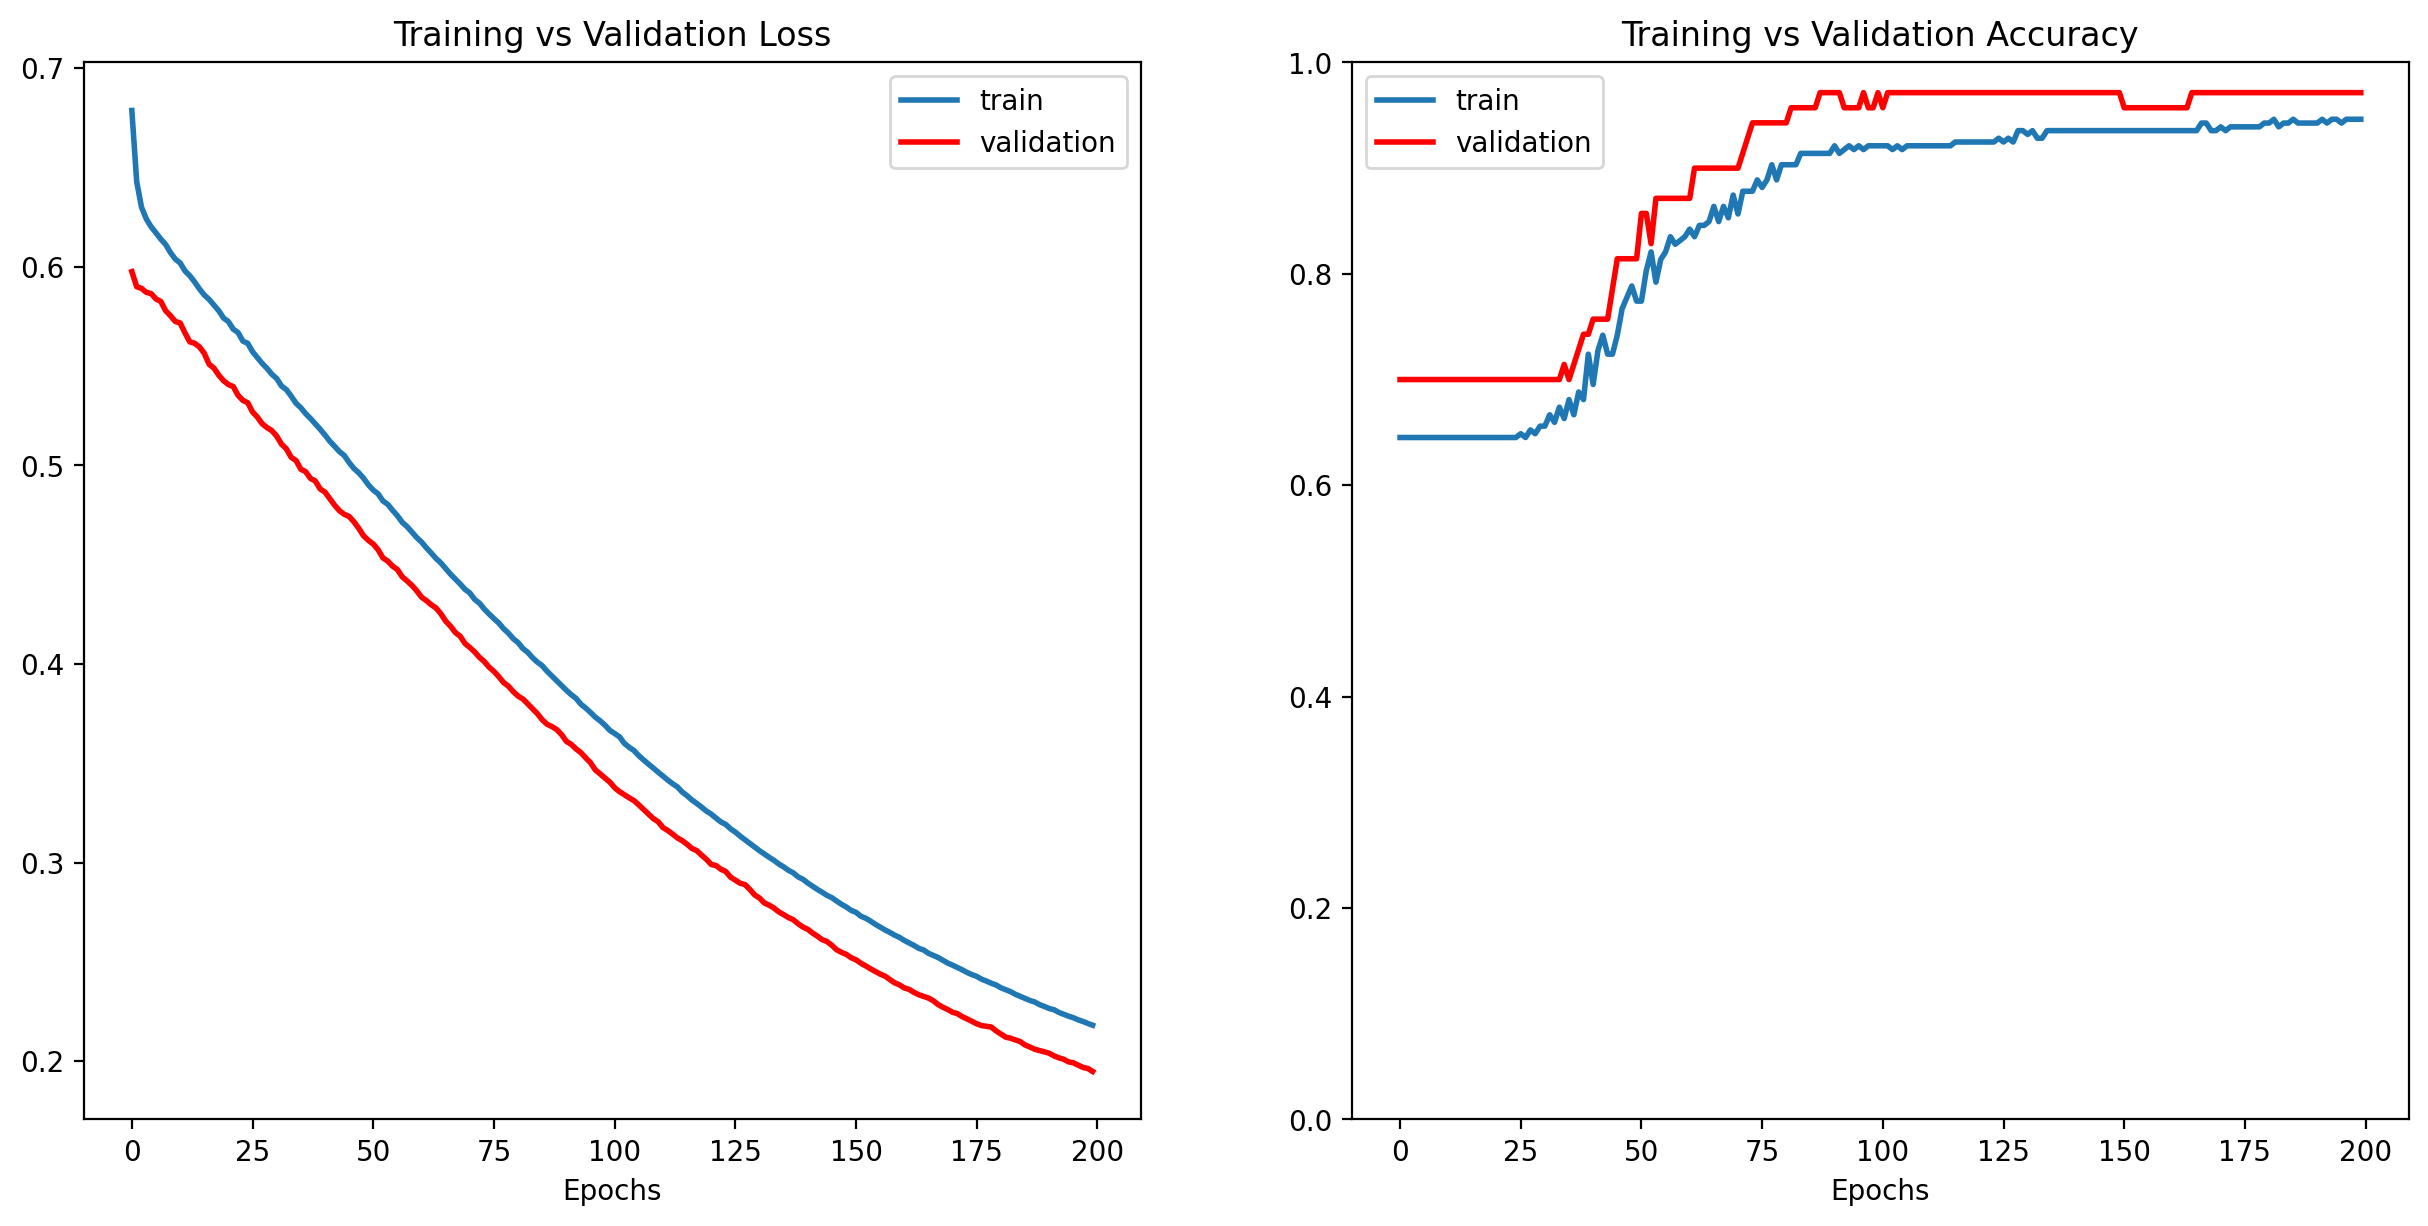

In [15]:
single_result = [i for i in single_results if i["nodes"] == 64 and i["epochs"] == 200][0]
single_history = single_result["history"]

fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.set_dpi(fig_dpi)

ax = axes[0]
ax.set_title("Training vs Validation Loss")
ax.plot(single_history.history['loss'], label="train", lw=2)
ax.plot(single_history.history['val_loss'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
ax.legend()

ax = axes[1]
ax.set_title("Training vs Validation Accuracy")
ax.plot(single_history.history['accuracy'], label="train", lw=2)
ax.plot(single_history.history['val_accuracy'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
ax.set_ylim(0, 1)
ax.legend()

print(f"Nodes: {single_result['nodes']}, Epochs: {single_result['epochs']}")
plt.show()

### Accuracy Surface

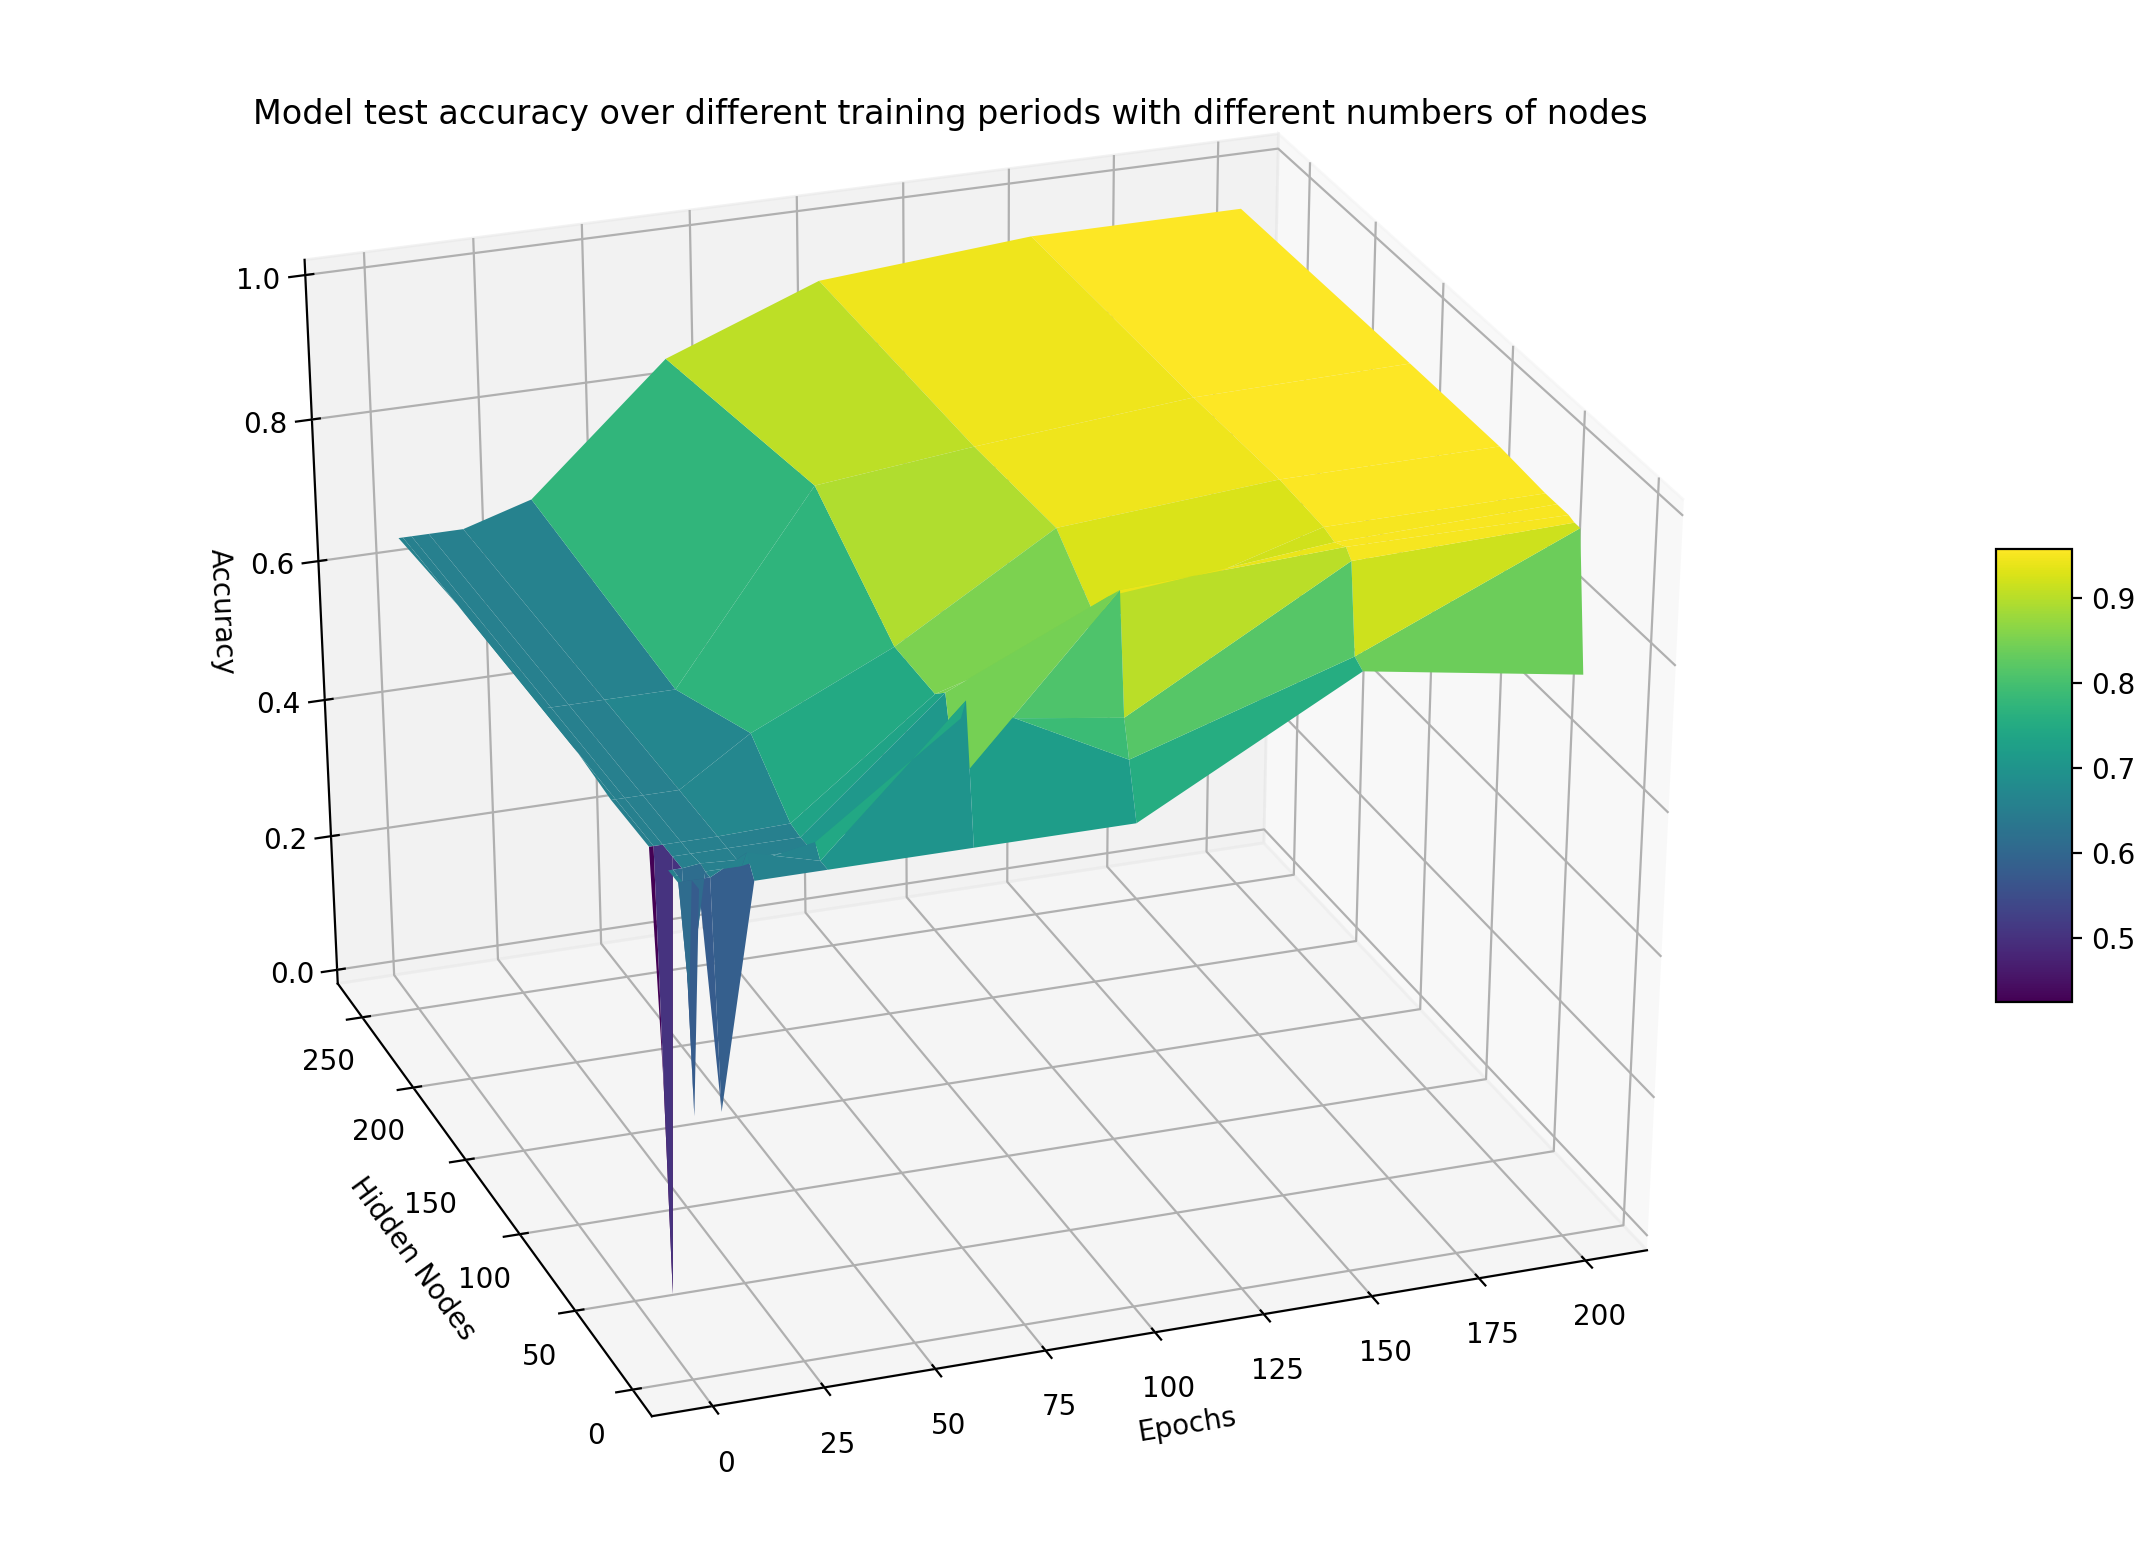

In [16]:
X, Y = np.meshgrid(epochs, hidden_nodes)

shaped_result = np.reshape([r["results"][1] for r in single_results], 
                           (len(hidden_nodes), len(epochs)))

fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, shaped_result, cmap='viridis')
ax.set_title('Model test accuracy over different training periods with different numbers of nodes')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.show()

### Error Rate Curves

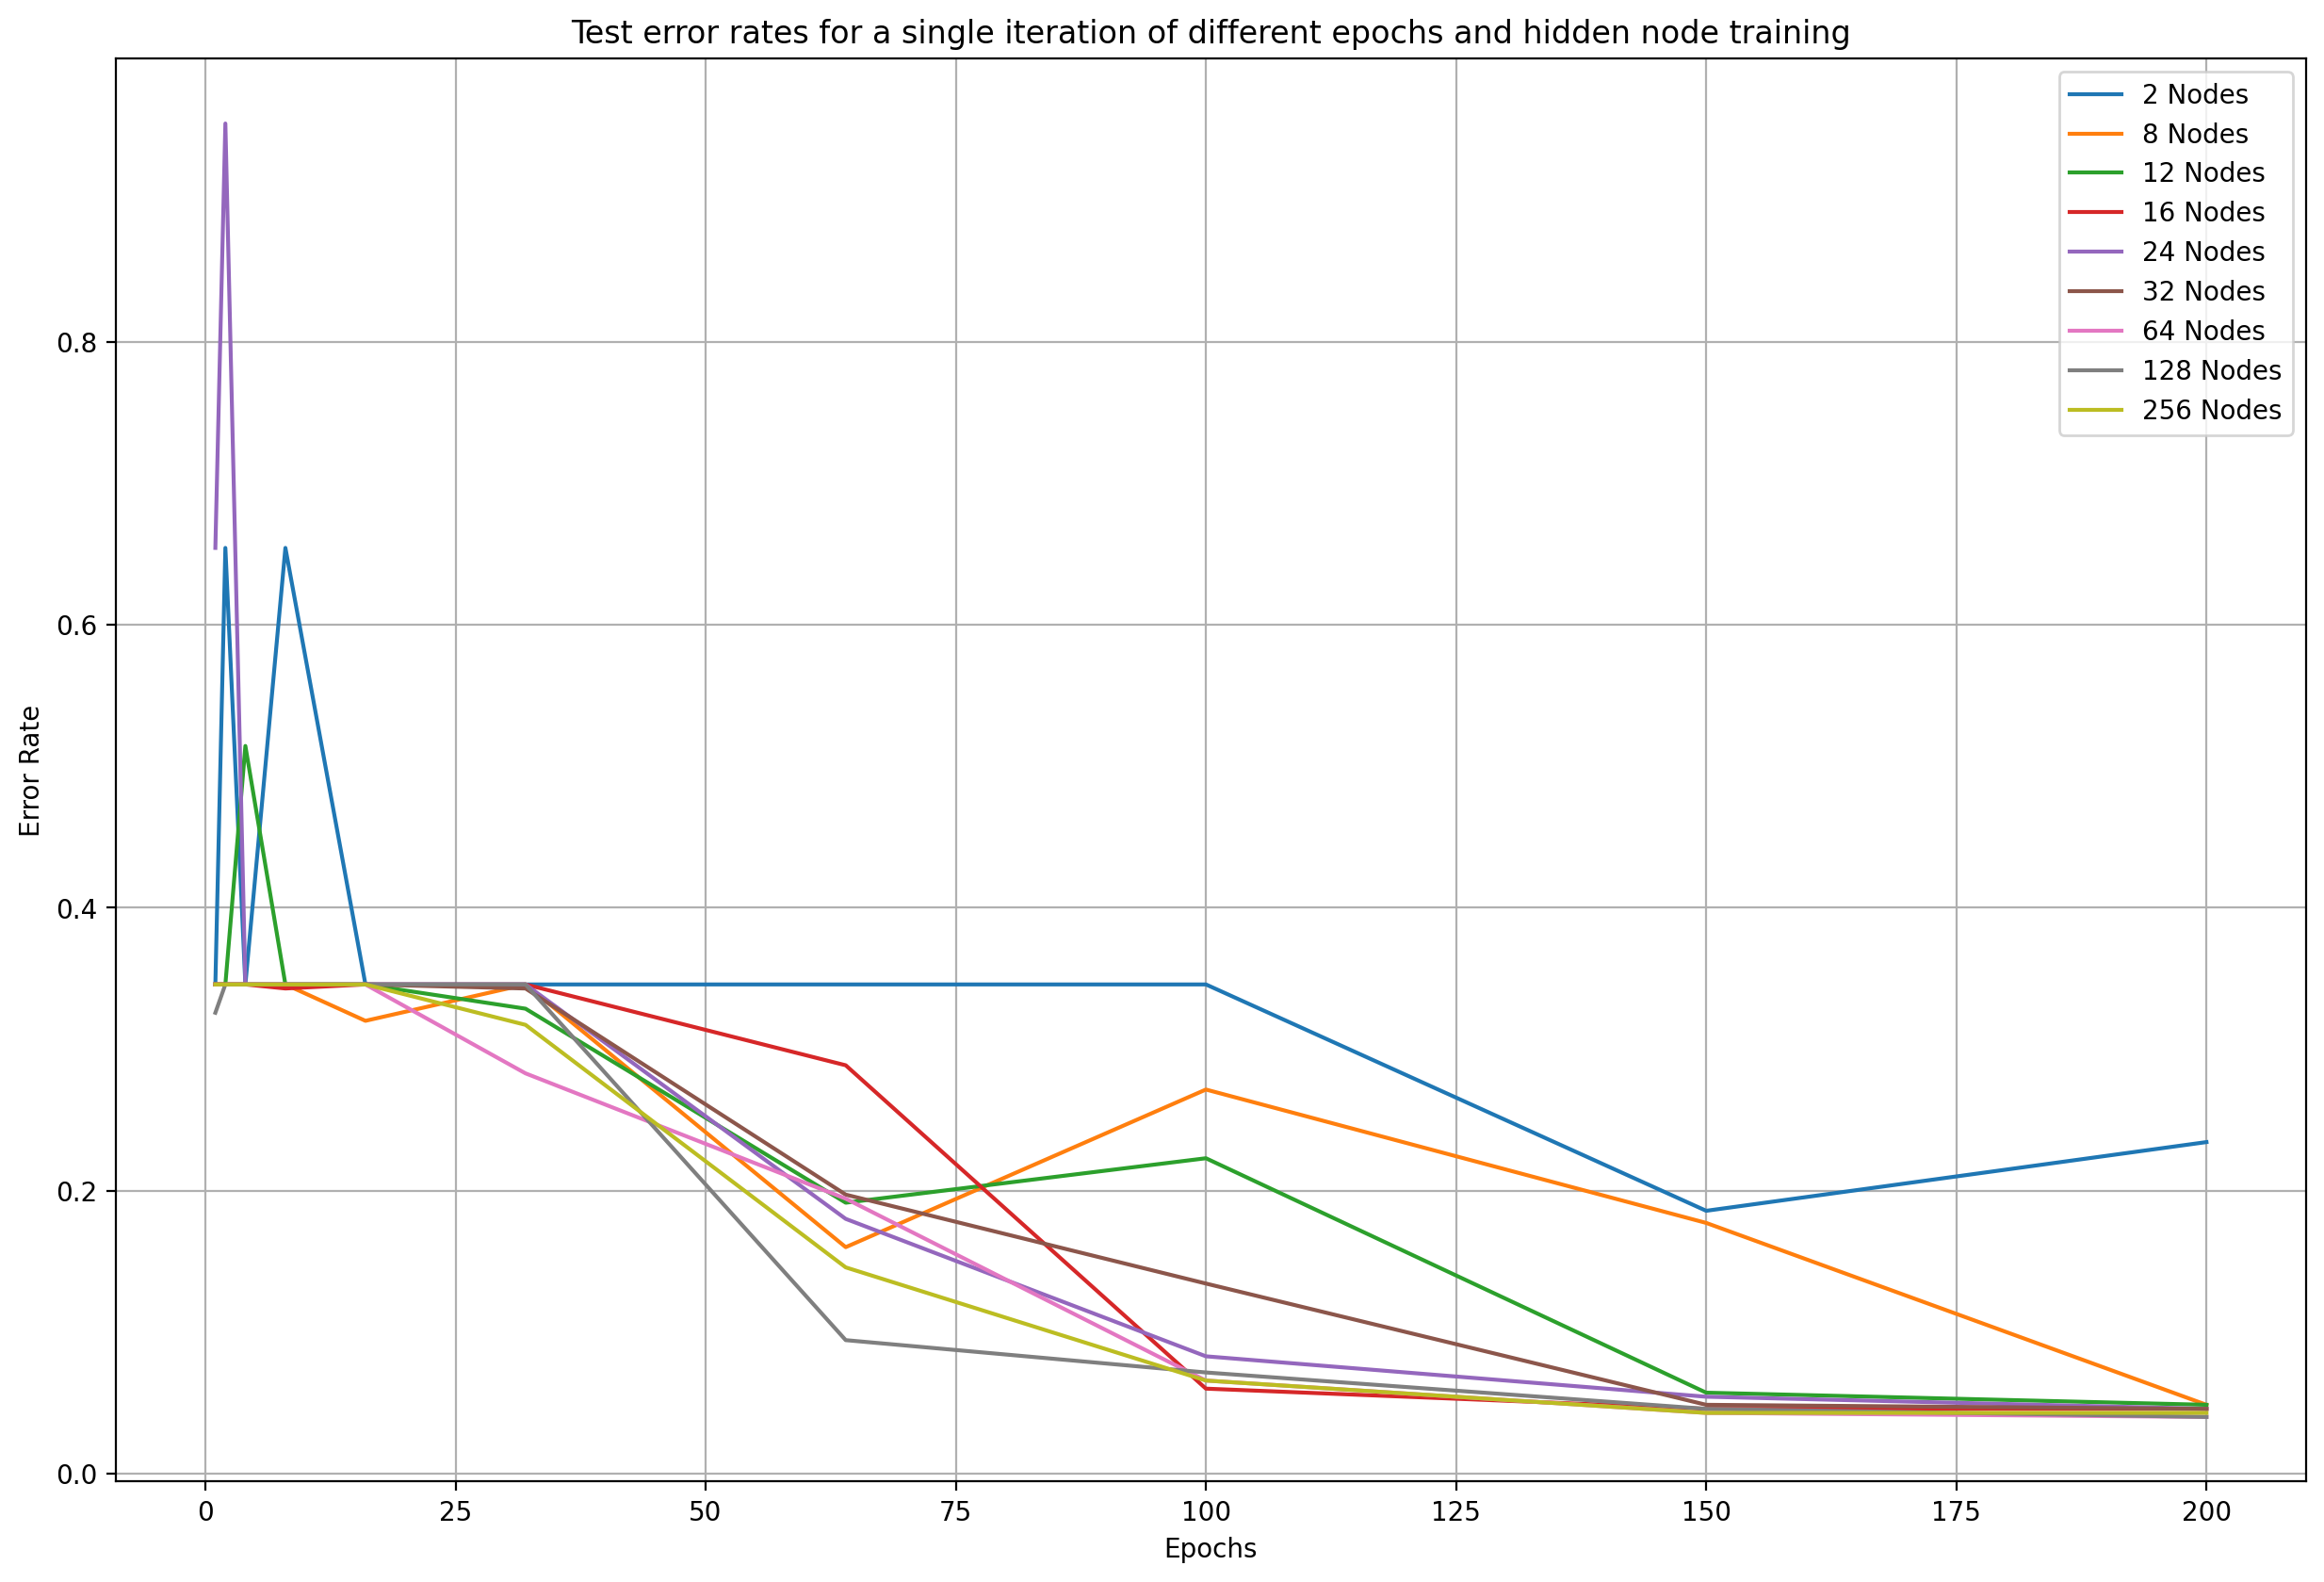

In [17]:
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)

for layer in hidden_nodes:
    plt.plot(epochs, 
             1 - np.array([i["results"][1] 
                  for i in single_results 
                  if i["nodes"] == layer]), 
             label=f'{layer} Nodes')

plt.legend()
plt.grid()
plt.title("Test error rates for a single iteration of different epochs and hidden node training")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.show()

## Multiple Iterations

Run multiple iterations of the epoch/layer investigations and average

In [ ]:
multi_results = list()
multi_iterations = 30
for i in range(multi_iterations):
    print(f"Iteration {i+1}/{multi_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, stratify=labels)
    multi_results.append(list(evaluate_parameters(data_train=data_train, 
                                                  data_test=data_test, 
                                                  labels_train=labels_train, 
                                                  labels_test=labels_test,
                                                  return_model=False,
                                                  print_params=False)))

In [ ]:
average_accuracy = np.zeros((len(hidden_nodes), len(epochs)))
for iteration in multi_results:
    for single_test in iteration:
        average_accuracy[hidden_nodes.index(single_test['nodes']), epochs.index(single_test['epochs'])] += single_test["results"][1]

average_accuracy = average_accuracy / len(multi_results)

In [ ]:
pd.DataFrame(average_accuracy)

In [ ]:
np.savetxt("multi-iteration.csv", average_accuracy, delimiter=',')

In [ ]:
X, Y = np.meshgrid(epochs, hidden_nodes)

fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, average_accuracy, cmap='coolwarm')
ax.set_title(f'Average Accuracy Over {multi_iterations} Iterations')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)

for idx, layer in enumerate(average_accuracy):
    plt.plot(epochs, 1 - layer, label=f'{hidden_nodes[idx]} Nodes')

plt.legend()
plt.grid()
plt.title(f"Error rates for different epochs and hidden nodes over {multi_iterations} iterations")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.show()

# Experiment 2

# Experiment 3